# Handling imbalanced data in Bank customer churn prediction

Dataset: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix , classification_report

## Data Ingestion

In [2]:
df = pd.read_csv('../08-customer_churn_pred\Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## EDA

In [3]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [4]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
def print_unique_col_values(df):
    for column in df:
        if df[column].dtypes == 'object':
            print(f'{column}: {df[column].unique()}')

print_unique_col_values(df)

Geography: ['France' 'Spain' 'Germany']
Gender: ['Female' 'Male']


## Data Visualization

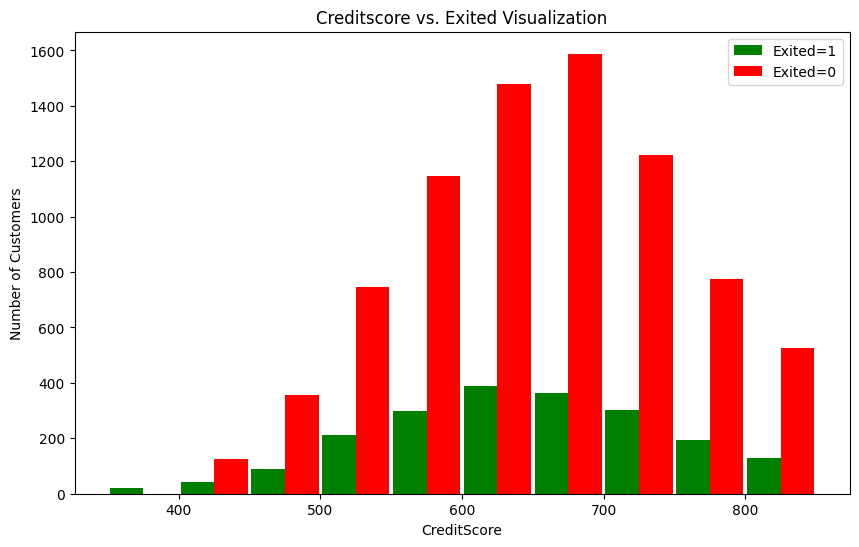

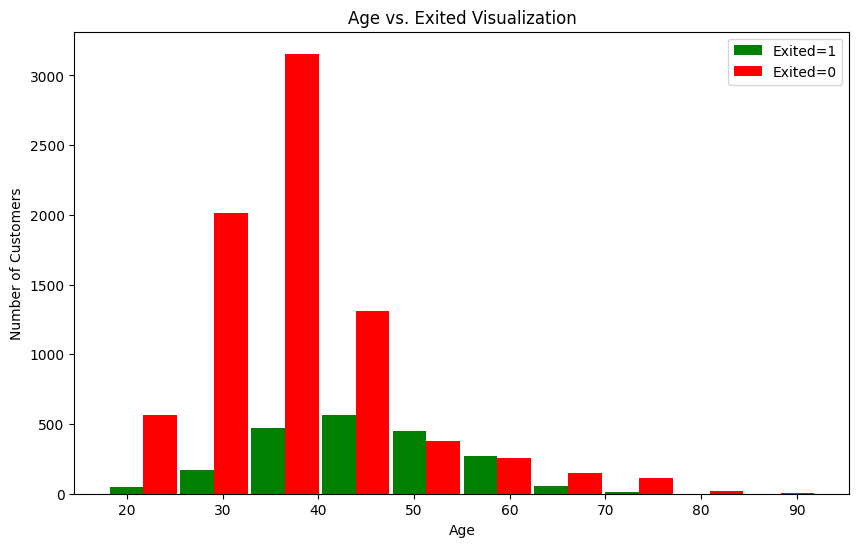

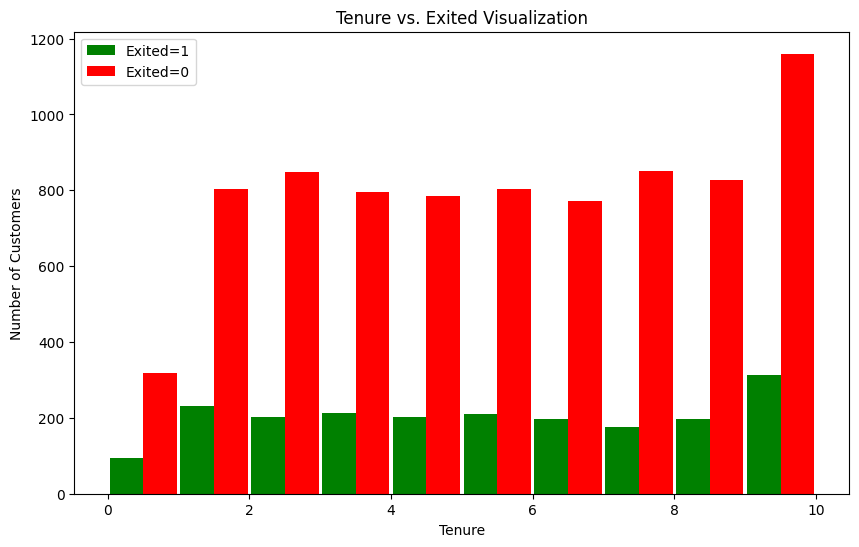

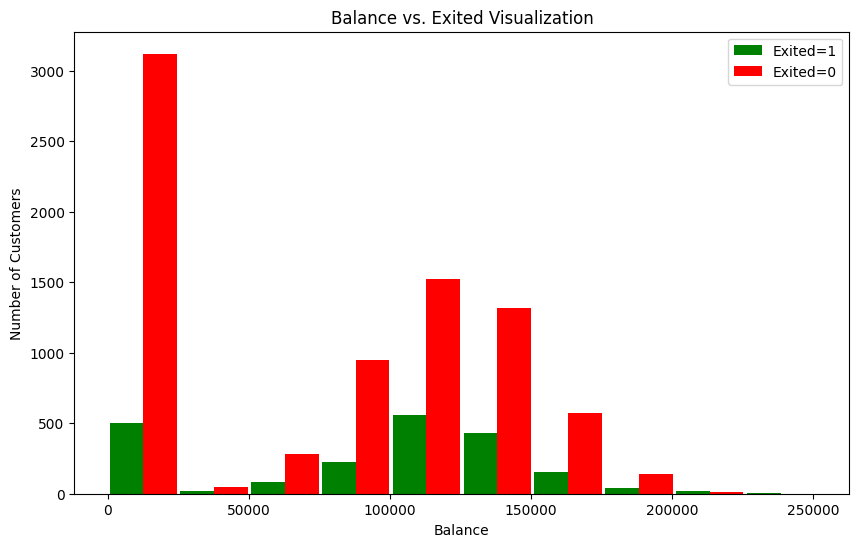

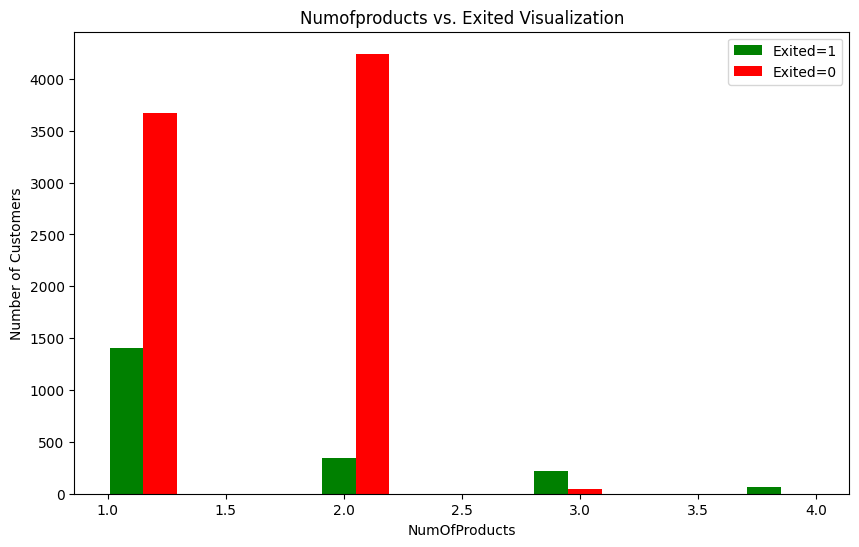

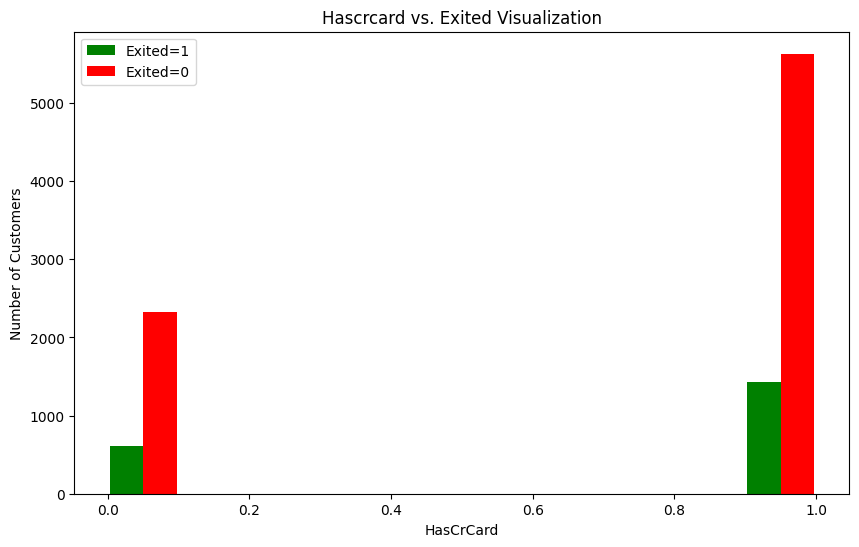

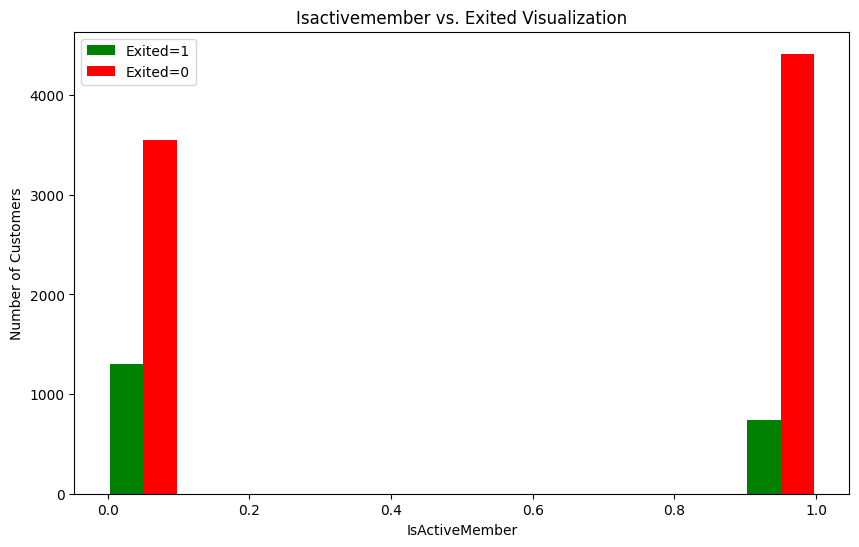

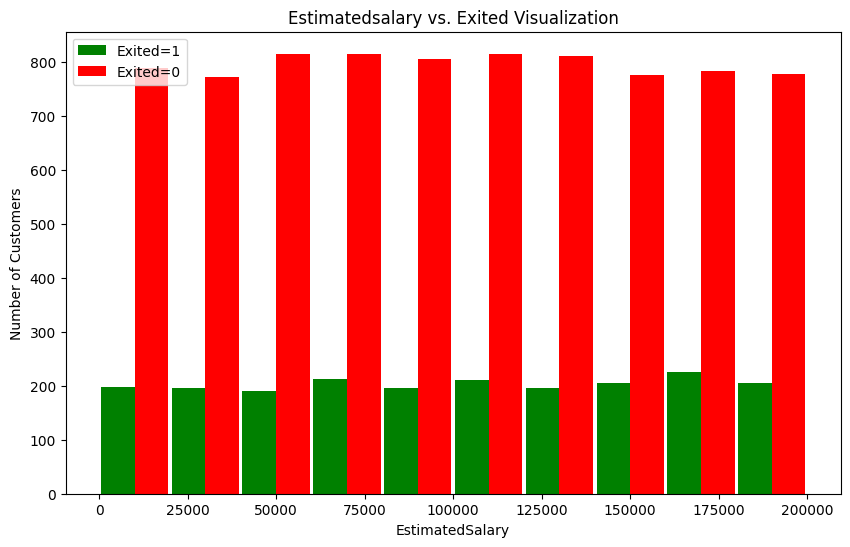

In [6]:
def plot_exited_distribution(df, target_column, feature_column, labels=(1, 0), colors=('green', 'red')):
    
    # Separating the data based on the target column
    feature_exited_yes = df[df[target_column] == labels[0]][feature_column]
    feature_exited_no = df[df[target_column] == labels[1]][feature_column]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.xlabel(feature_column)
    plt.ylabel("Number of Customers")
    plt.title(f"{feature_column.capitalize()} vs. {target_column.capitalize()} Visualization")

    # Plot histogram
    plt.hist([feature_exited_yes, feature_exited_no], rwidth=0.95, color=colors, label=[f"{target_column}={labels[0]}", f"{target_column}={labels[1]}"])
    plt.legend()
    plt.show()

cols_to_plot = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

for col in cols_to_plot:
    plot_exited_distribution(df, target_column='Exited', feature_column=col)

## Data Pre-processing

### Encoding

In [7]:
df1 = pd.get_dummies(data=df, columns=['Geography', 'Gender'])
df1

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,True,False,False,True,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,True,False,False,True,False
3,699,39,1,0.00,2,0,0,93826.63,0,True,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,True,False,False,False,True
9996,516,35,10,57369.61,1,1,1,101699.77,0,True,False,False,False,True
9997,709,36,7,0.00,1,0,1,42085.58,1,True,False,False,True,False
9998,772,42,3,75075.31,2,1,0,92888.52,1,False,True,False,False,True


In [8]:
boolean_cols = ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']

# Convert boolean columns to integer (1 for True, 0 for False)
for col in boolean_cols:
    df1[col] = df1[col].astype(int)

### Scaling

In [9]:
cols_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = MinMaxScaler()

df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])

def print_unique_col(df):
    for column in df:
        print(f'{column}: {df[column].unique()}')

print_unique_col(df1)

CreditScore: [0.538 0.516 0.304 0.698 1.    0.59  0.944 0.052 0.302 0.668 0.356 0.294
 0.252 0.398 0.57  0.532 0.606 0.474 0.752 0.764 0.572 0.32  0.638 0.992
 0.454 0.812 0.442 0.448 0.122 0.482 0.366 0.406 0.34  0.744 0.25  0.28
 0.908 0.464 0.244 0.23  0.412 0.968 0.62  0.852 0.958 0.574 0.4   0.696
 0.47  0.876 0.61  0.502 0.612 0.75  0.322 0.528 0.784 0.674 0.41  0.506
 0.802 0.462 0.77  0.622 0.65  0.776 0.926 0.614 0.508 0.338 0.628 0.656
 0.814 0.132 0.63  0.854 0.386 0.312 0.286 0.604 0.8   0.758 0.592 0.594
 0.916 0.348 0.838 0.76  0.33  0.846 0.928 0.72  0.126 0.546 0.64  0.544
 0.87  0.51  0.258 0.67  0.376 0.424 0.742 0.556 0.636 0.956 0.648 0.55
 0.164 0.84  0.816 0.89  0.672 0.878 0.478 0.222 0.468 0.458 0.626 0.664
 0.886 0.682 0.27  0.6   0.808 0.37  0.732 0.378 0.712 0.472 0.562 0.734
 0.9   0.666 0.708 0.53  0.634 0.268 0.26  0.456 0.324 0.512 0.494 0.856
 0.328 0.35  0.73  0.46  0.914 0.342 0.818 0.332 0.722 0.536 0.586 0.642
 0.678 0.54  0.652 0.444 0.69  0.484 0.4

### Train Test Split

In [10]:
X = df1.drop('Exited', axis='columns')
y = df1['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 13) (2000, 13) (8000,) (2000,)


## Model

In [12]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    
    model = keras.Sequential([
        keras.layers.Dense(10, input_shape=(13,), activation='relu'),
        keras.layers.Dense(5, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='SGD', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight = weights)
    
    print(model.evaluate(X_test, y_test))
    
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    
    print("Classification Report: \n", classification_report(y_test, y_pred))
    
    return y_pred

In [13]:
y_pred = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7814 - loss: 0.5419
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7921 - loss: 0.5000
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7944 - loss: 0.4917
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7871 - loss: 0.4941
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7985 - loss: 0.4779
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7931 - loss: 0.4808
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7865 - loss: 0.4875
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7958 - loss: 0.4785
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8000 - loss: 0.4673
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7942 - loss: 0.4698
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7946 - loss: 0.4677
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━━

* F1 for 0: 0.90
* F1 for 1: 0.38
* Accuracy: 0.83

## Mitigating Skewdness of Data

In [14]:
# Class count
count_class_0, count_class_1 = df1.Exited.value_counts()

# Divide by class
df_class_0 = df1[df1['Exited'] == 0]
df_class_1 = df1[df1['Exited'] == 1]

### Method 1: Undersampling

In [15]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Exited.value_counts())

X = df_test_under.drop('Exited', axis='columns')
y = df_test_under['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

print(y_train.value_counts())
print(y_test.value_counts())

y_pred = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Random under-sampling:
Exited
0    2037
1    2037
Name: count, dtype: int64
Exited
1    1630
0    1629
Name: count, dtype: int64
Exited
0    408
1    407
Name: count, dtype: int64
Epoch 1/100


c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4836 - loss: 0.7013
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5194 - loss: 0.6927
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5557 - loss: 0.6879
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5470 - loss: 0.6877
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5473 - loss: 0.6874
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5494 - loss: 0.6847
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5545 - loss: 0.6823
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5704 - loss: 0.6792
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5695 - loss: 0.6787
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5981 - loss: 0.6706
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6161 - loss: 0.6661
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

* F1 for 0: 0.90 -> 0.72
* F1 for 1: 0.38 -> 0.72
* Accuracy: 0.83 -> 0.72

### Method 2: Oversampling

In [16]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Exited.value_counts())

X = df_test_over.drop('Exited',axis='columns')
y = df_test_over['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

print(y_train.value_counts())
print(y_test.value_counts())

y_pred = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Random over-sampling:
Exited
0    7963
1    7963
Name: count, dtype: int64
Exited
0    6370
1    6370
Name: count, dtype: int64
Exited
0    1593
1    1593
Name: count, dtype: int64
Epoch 1/100


c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4848 - loss: 0.6973
Epoch 2/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5333 - loss: 0.6919
Epoch 3/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5775 - loss: 0.6874
Epoch 4/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5920 - loss: 0.6814
Epoch 5/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6066 - loss: 0.6746
Epoch 6/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6222 - loss: 0.6655
Epoch 7/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6282 - loss: 0.6582
Epoch 8/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6337 - loss: 0.6461
Epoch 9/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6361 - loss: 0.6390
Epoch 10/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6311 - loss: 0.6374
Epoch 11/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6459 - loss: 0.6309
Epoch 12/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

* F1 for 0: 0.90 -> 0.72 -> 0.74
* F1 for 1: 0.38 -> 0.72 -> 0.67
* Accuracy: 0.83 -> 0.72 -> 0.71

### Method 3: SMOTE

In [18]:
X = df1.drop('Exited', axis='columns')
y = df1['Exited']

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

print(y_sm.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

print(y_train.value_counts())
print(y_test.value_counts())

y_pred = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Exited
1    7963
0    7963
Name: count, dtype: int64
Exited
0    6370
1    6370
Name: count, dtype: int64
Exited
0    1593
1    1593
Name: count, dtype: int64
Epoch 1/100


c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5966 - loss: 0.6713
Epoch 2/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6358 - loss: 0.6530
Epoch 3/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6296 - loss: 0.6478
Epoch 4/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6342 - loss: 0.6423
Epoch 5/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6428 - loss: 0.6327
Epoch 6/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6438 - loss: 0.6298
Epoch 7/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6571 - loss: 0.6188
Epoch 8/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6571 - loss: 0.6174
Epoch 9/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6701 - loss: 0.6101
Epoch 10/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6733 - loss: 0.6041
Epoch 11/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6855 - loss: 0.5934
Epoch 12/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

* F1 for 0: 0.90 -> 0.72 -> 0.74 -> 0.79
* F1 for 1: 0.38 -> 0.72 -> 0.67 -> 0.78
* Accuracy: 0.83 -> 0.72 -> 0.71 -> 0.78

### Method 4: Ensemble with undersampling

In [20]:
print(df1.Exited.value_counts())

# Regain Original features and labels
X = df1.drop('Exited',axis='columns')
y = df1['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

print(y_train.value_counts())
print(y_test.value_counts())

Exited
0    7963
1    2037
Name: count, dtype: int64
Exited
0    6370
1    1630
Name: count, dtype: int64
Exited
0    1593
1     407
Name: count, dtype: int64


In [22]:
6370/1630

3.9079754601226995

In [23]:
6370/4

1592.5

In [24]:
1630*4

6520

In [21]:
df2 = X_train.copy()
df2['Exited'] = y_train

df2_class0 = df2[df2.Exited == 0]
df2_class1 = df2[df2.Exited == 1]

def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)

    X_train = df_train.drop('Exited', axis='columns')
    y_train = df_train.Exited
    return X_train, y_train

**Ensemble (with 4 batches)**

model_1 -> class_1(1495) + class_0(0, 1630)

model_2 -> class_1(1495) + class_0(1630, 3260)

model_3 -> class_1(1495) + class_0(3260, 4890)

model_4 -> class_1(1495) + class_0(4890, 6370)

In [ ]:
X_train, y_train = get_train_batch(df2_class0, df2_class1, 0, 1630)

y_pred1 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5056 - loss: 0.7023
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5342 - loss: 0.6923
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5567 - loss: 0.6859
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5863 - loss: 0.6786
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5831 - loss: 0.6771
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6012 - loss: 0.6689
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6133 - loss: 0.6651
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.6068 - loss: 0.6619
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.6187 - loss: 0.6590
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.6438 - loss: 0.6528
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.6390 - loss: 0.6491
Epoch 12/100
102/102 ━━━━━━━━━━━━

In [ ]:
X_train, y_train = get_train_batch(df2_class0, df2_class1, 1630, 3260)

y_pred2 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100


c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4706 - loss: 0.7109
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4679 - loss: 0.7027
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4832 - loss: 0.6984
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4871 - loss: 0.6965
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4893 - loss: 0.6956
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5172 - loss: 0.6939
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5217 - loss: 0.6917
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5476 - loss: 0.6893
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5684 - loss: 0.6898
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5708 - loss: 0.6873
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5708 - loss: 0.6861
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [ ]:
X_train, y_train = get_train_batch(df2_class0, df2_class1, 3260, 4890)

y_pred3 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100


c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4965 - loss: 0.7548
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5067 - loss: 0.6974
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5359 - loss: 0.6876
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5641 - loss: 0.6808
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5885 - loss: 0.6755
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5981 - loss: 0.6736
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6149 - loss: 0.6684
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6277 - loss: 0.6631
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6218 - loss: 0.6619
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6368 - loss: 0.6603
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6208 - loss: 0.6608
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [ ]:
X_train, y_train = get_train_batch(df2_class0, df2_class1, 4890, 6370)

y_pred4 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100


c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5565 - loss: 0.6872
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5744 - loss: 0.6723
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5934 - loss: 0.6589
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6194 - loss: 0.6503
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6285 - loss: 0.6455
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 0.6397
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6322 - loss: 0.6410
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6537 - loss: 0.6297
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6405 - loss: 0.6339
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6529 - loss: 0.6307
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6512 - loss: 0.6278
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6535 - lo

In [ ]:
y_pred_final = y_pred1.copy()
for i in range(len(y_pred1)):
    n_ones = y_pred1[i] + y_pred2[i] + y_pred3[i] + y_pred4[i]
    if n_ones>1:
        y_pred_final[i] = 1
    else:
        y_pred_final[i] = 0

cl_rep = classification_report(y_test, y_pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1593
           1       0.38      0.73      0.50       407

    accuracy                           0.70      2000
   macro avg       0.65      0.71      0.64      2000
weighted avg       0.80      0.70      0.73      2000



In [31]:
def batch_train_predict(df_class0, df_class1, sample_range, X_test, y_test):
    # List to store predictions from each batch
    all_preds = []
    
    for i in range(len(sample_range) - 1):
        # Define the start and end indices for the current batch
        start, end = sample_range[i], sample_range[i + 1]

        # Get the training batch
        X_train, y_train = get_train_batch(df_class0, df_class1, start, end)

        # Get predictions and store them
        y_pred = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)
        all_preds.append(y_pred)

    return all_preds

# Define the sample range
sample_range = [0, 1630, 3260, 4890, 6370]

# Call the function
all_preds = batch_train_predict(df2_class0, df2_class1, sample_range, X_test, y_test)

# Ensemble logic: majority voting
y_pred_final = all_preds[0].copy()
for i in range(len(y_pred_final)):
    n_ones = sum(pred[i] for pred in all_preds)
    y_pred_final[i] = 1 if n_ones > 1 else 0

# Evaluate
cl_rep = classification_report(y_test, y_pred_final)
print(cl_rep)

Epoch 1/100


c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4904 - loss: 0.7078
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5255 - loss: 0.6952
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4709 - loss: 0.6974
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5011 - loss: 0.6936
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5199 - loss: 0.6917
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5125 - loss: 0.6917
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.5534 - loss: 0.6889
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5502 - loss: 0.6877
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5878 - loss: 0.6840
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5792 - loss: 0.6832
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5905 - loss: 0.6812
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5060 - loss: 0.7250
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5521 - loss: 0.6888
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5673 - loss: 0.6789
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6036 - loss: 0.6654
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6169 - loss: 0.6561
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6245 - loss: 0.6498
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6334 - loss: 0.6404
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6435 - loss: 0.6397
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6452 - loss: 0.6349
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6479 - loss: 0.6323
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6564 - loss: 0.6299
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━

c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5162 - loss: 0.7134
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5811 - loss: 0.6902
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5908 - loss: 0.6810
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5970 - loss: 0.6785
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6075 - loss: 0.6771
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6043 - loss: 0.6760
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6022 - loss: 0.6735
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5993 - loss: 0.6721
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6179 - loss: 0.6685
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6228 - loss: 0.6647
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6271 - loss: 0.6608
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

c:\Users\Hp\Documents\GitHub\practice-dl\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4938 - loss: 0.6987
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5491 - loss: 0.6914
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5744 - loss: 0.6834
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5860 - loss: 0.6782
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6069 - loss: 0.6719
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6239 - loss: 0.6650
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6148 - loss: 0.6670
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6368 - loss: 0.6554
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6352 - loss: 0.6481
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6156 - loss: 0.6503
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6196 - loss: 0.6476
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6260 - lo

* F1 for 0: 0.90 -> 0.72 -> 0.74 -> 0.79 -> 0.79
* F1 for 1: 0.38 -> 0.72 -> 0.67 -> 0.78 -> 0.50
* Accuracy: 0.83 -> 0.72 -> 0.71 -> 0.78 -> 0.70